In [4]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# features.txt 파일에는 피처 이름 index와 피처명이 공백으로 분리되어 있음.DF로 로드.

feature_name_df = pd.read_csv('features.txt', sep='\s+',
                              header = None, names=['column_index', 'column_name'])

# 피처명 index 제거. 피처명 리스트 객체로 생성 뒤 샘플로 10개만 추출
feature_name = feature_name_df.iloc[:, 1].values.tolist()
print('전체 피처명에서 10개만 추출:', feature_name[:10])

전체 피처명에서 10개만 추출: ['tBodyAcc-mean()-X', 'tBodyAcc-mean()-Y', 'tBodyAcc-mean()-Z', 'tBodyAcc-std()-X', 'tBodyAcc-std()-Y', 'tBodyAcc-std()-Z', 'tBodyAcc-mad()-X', 'tBodyAcc-mad()-Y', 'tBodyAcc-mad()-Z', 'tBodyAcc-max()-X']


In [7]:
# Duplicated features
feature_dup_df = feature_name_df.groupby('column_name').count()
print(feature_dup_df[feature_dup_df['column_index'] > 1].count())
feature_dup_df[feature_dup_df['column_index'] > 1].head()

column_index    42
dtype: int64


,column_index
column_name,
"fBodyAcc-bandsEnergy()-1,16",3
"fBodyAcc-bandsEnergy()-1,24",3
"fBodyAcc-bandsEnergy()-1,8",3
"fBodyAcc-bandsEnergy()-17,24",3
"fBodyAcc-bandsEnergy()-17,32",3


In [11]:
# 중복되는 feature명에 _1을 또는 _2를 붙여주기 위해서 함수만들기.
def get_new_feature_name_df(old_feature_name_df):
    feature_dup_df = pd.DataFrame(data=old_feature_name_df.groupby('column_name').cumcount(), #cumcount는 0,1,2,3 누적카운트
                                  columns=['dup_cnt'])
    feature_dup_df = feature_dup_df.reset_index() #누적 카운트된 df를 reset_index해주고
    new_feature_name_df = pd.merge(old_feature_name_df.reset_index(), feature_dup_df, how='outer') #left 컬럼명과 right에 있는 숫자를 outer 조인을 통해서 숫자를 부여해줌.
    #새로운 컬럼 'column_name'은 column_name과 중복값을 적은 상태에서 lambda 함수 취해줌. 람다내용 이해못함. 
    new_feature_name_df['column_name'] = new_feature_name_df[['column_name',
                                                              'dup_cnt']].apply(lambda x :x[0]+'_'+str(x[1]) if x[1] >0 
                                                                                                            else x[0], axis=1)
    #reset 인덱스를 통해서 매겼던 index 삭제
    new_feature_name_df = new_feature_name_df.drop(['index'], axis=1)
    return new_feature_name_df

In [13]:
# function (method) get_new_feature_name_df는 feature_name_df를 old_feature_name_df로 받아서, feature_dup_df에 집어넣고 cumcount를 하면서 columns에 숫잘르 집어넣었따.
# 생성된 feature_dup_df 데이터프레임에 rest_index를 해주어서 총 갯수를 나타내주었다.
# new_feature_name_df는 맨 초기의 feature_name_df에서 reset_index를 해주고난 것과, 누적카운트된 column name을 merge해주었다. merge 해주면 column_name이 중복되지만
# 'column_name'이라는 새로운 empty 컬럼을 지정해준 뒤, column_name과 dup_cnt를 싸잡아놓은 뒤에, x의 0번쨰 즉 column_name과 '_'를 더하고.
# 문자열x[1] 즉 숫자를 더해주었는데 만약 x[1]가 0보다 크면 더하는 방식으로 하였다. 만약 x[1]이 0보다 크지 않으면 일반 column name만 도출하게 하였다.
get_new_feature_name_df(feature_name_df)

,column_index,column_name,dup_cnt
0,1,tBodyAcc-mean()-X,0
1,2,tBodyAcc-mean()-Y,0
2,3,tBodyAcc-mean()-Z,0
3,4,tBodyAcc-std()-X,0
4,5,tBodyAcc-std()-Y,0
...,...,...,...
556,557,"angle(tBodyGyroMean,gravityMean)",0
557,558,"angle(tBodyGyroJerkMean,gravityMean)",0
558,559,"angle(X,gravityMean)",0
559,560,"angle(Y,gravityMean)",0


In [18]:
import pandas as pd

def get_human_dataset():
    # 각 데이터 파일은 공백으로 분리되어 있으므로 read_csv에서 공백문자를 sep으로 할당.
    feature_name_df = pd.read_csv('features.txt', sep='\s+',
                                  header = None, names = ['column_index', 'column_name'])
    # 중복된 피처명 수정하는 get_new_feature_name_df()를 이용, 신규 피처명 DF 생성
    new_feature_name_df = get_new_feature_name_df(feature_name_df)
    # DF에 피처명을 칼럼으로 부여하기 위해 리스트 객체로 다시 변환
    feature_name = new_feature_name_df.iloc[:, 1].values.tolist()
    # 학습 피처 데이터세트와 테스트 피처 데이터를 DF로 로딩. 칼럼명은 feature_name 적용
    X_train = pd.read_csv('train/X_train.txt', sep='\s+', names=feature_name)
    X_test = pd.read_csv('test/X_test.txt', sep='\s+', names=feature_name)
    
    # 학습 레이블과 테스트 레이블 데이터를 DF로 로딩하고 칼럼명은 action으로 부여
    y_train = pd.read_csv('train/y_train.txt', sep='\s+', header=None, names=['action'])
    y_test = pd.read_csv('test/y_test.txt', sep='\s+', header=None, names=['action'])
    
    # 로드된 학습/테스트용 DF 모두 반환
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = get_human_dataset()

In [19]:
print('## 학습 피처 데이터셋 info()')
print(X_train.info())

## 학습 피처 데이터셋 info()
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7352 entries, 0 to 7351
Columns: 561 entries, tBodyAcc-mean()-X to angle(Z,gravityMean)
dtypes: float64(561)
memory usage: 31.5 MB
None


In [21]:
#고르게 분포된 타겟값
print(y_train['action'].value_counts())

6    1407
5    1374
4    1286
1    1226
2    1073
3     986
Name: action, dtype: int64


In [24]:
# DecisionTreeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# random_state =42
dt_clf = DecisionTreeClassifier(random_state=42)
dt_clf.fit(X_train, y_train)
pred = dt_clf.predict(X_test)
accuracy = accuracy_score(y_test, pred)
print('dt clf accuracy: {0:.4f}'.format(accuracy))

# Dt clf hyperparameter extraction
print('DecisionTreeClassifier 기본 하이퍼 파라미터:\n', dt_clf.get_params())

dt clf accuracy: 0.8622
DecisionTreeClassifier 기본 하이퍼 파라미터:
 {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': 42, 'splitter': 'best'}


In [28]:
#5개의 cross validation
from sklearn.model_selection import GridSearchCV

params = {
    'max_depth' : [6, 8, 10 ,12, 16, 20, 24]
}

grid_cv = GridSearchCV(dt_clf, param_grid=params, scoring='accuracy', cv=5, verbose=1)
grid_cv.fit(X_train, y_train)
print(grid_cv.best_score_)
print(grid_cv.best_params_)

Fitting 5 folds for each of 7 candidates, totalling 35 fits
0.847940824188275


AttributeError: 'GridSearchCV' object has no attribute 'best_params'

In [27]:
# GridSearchCV 객체의 cv_results_ 속성을 DF로 생성.
cv_results_df = pd.DataFrame(grid_cv.cv_results_)
# max_depth 파라미터 값과 그때의 테스트 세트, 학습 데이터 세트의 정확도 수치 추출
cv_results_df[['param_max_depth', 'mean_test_score']]

,param_max_depth,mean_test_score
0,6,0.846303
1,8,0.847941
2,10,0.840464
3,12,0.843319
4,16,0.845358
5,20,0.845086
6,24,0.847397


In [31]:
# test_set cross validation
max_depths = [6, 8, 10, 12, 16, 20, 24]
# max_depth 값을 변환 시키면서 학습과 테스트 세트에서의 예측 성능 측정
for depth in max_depths:
    dt_clf = DecisionTreeClassifier(max_depth=depth, random_state=42)
    dt_clf.fit(X_train, y_train)
    pred = dt_clf.predict(X_test)
    accuracy = accuracy_score(y_test, pred)
    print('max_depth = {0} 정확도: {1:.4f}'.format(depth, accuracy))

max_depth = 6 정확도: 0.8544
max_depth = 8 정확도: 0.8683
max_depth = 10 정확도: 0.8626
max_depth = 12 정확도: 0.8643
max_depth = 16 정확도: 0.8595
max_depth = 20 정확도: 0.8622
max_depth = 24 정확도: 0.8622


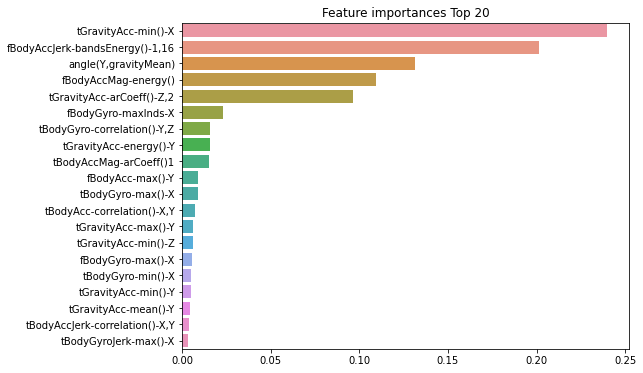

In [37]:
## 결정 트리에서 중요피처
import seaborn as sns

ftr_importances_values = dt_clf.feature_importances_
# Top 중요도로 정렬을 쉽게하고, seaborn 막대그래프로 쉽게 표현하기 위해 Series로 변환하였다.
ftr_importances = pd.Series(ftr_importances_values, index=X_train.columns)
# 중요도값 순으로 Series 정렬
ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]
plt.figure(figsize=(8, 6))
plt.title('Feature importances Top 20')
sns.barplot(x=ftr_top20, y=ftr_top20.index)
plt.show()